# *This file allows to generate all plots necessary for figures*

# **Useful packages and functions**

In [1]:
using DifferentialEquations, Plots, LaTeXStrings, ColorSchemes, DelimitedFiles, Plots.PlotMeasures
include("DA_utils.jl"); # Loading of some utils functions

# **Global variables**

In [2]:
# Definition of simulation time (in ms)
const Tfinal = 20000
const tspan  = (0.0, Tfinal)
tt = 0. : 0.01 : Tfinal
tt_rand = 0. : 1 : Tfinal

# Definition of reversal potential values (in mV), [Mg] and membrane capacitance
const VNa     = 115. - 65. # Sodium reversal potential
const VK      = -12. - 65. # Potassium reversal potential
const VL      = 10.6 - 65. # Leak reversal potential
const DA_VNa     = 60. # Sodium reversal potential
const DA_VK      = -90. # Potassium reversal potential
const DA_VL      = -65. # Leak reversal potential
const EPacemaker = 4.2732015978991615 # Reversal potential of pacemaking channels

const C       = 1. # Membrane capacitance

# Definition of voltage range for the DICs
const Vmin = -100 
const Vmax = 50
const Vrange = range(Vmin, stop=Vmax, step=0.0154640);

In [3]:
# Modifying backend GR attributes
gr(guidefontsize=25, tickfontsize=15, legendfontsize=12, margin=5Plots.mm, grid=false)
myApple = RGBA(187/255, 206/255, 131/255, 1)
mySalmon = RGBA(243/255, 124/255, 130/255)
myYellow = RGBA(228/255, 205/255, 121/255, 1)
myBlue = RGBA(131/255, 174/255, 218/255, 1)
myDarkBlue = RGBA(114/255, 119/255, 217/255, 1)
myOrange = RGBA(241/255, 175/255, 113/255, 1)
myPink = RGBA(243/255, 124/255, 130/255, 1)
myPurple = RGBA(169/255, 90/255, 179/255, 1)
myGreen = RGBA(132/255, 195/255, 168/255, 1)
myRed = RGBA(158/255, 3/255, 8/255, 1)
myGray = RGBA(150/255, 150/255, 150/255, 1)
myLightBlue = RGBA(127/255, 154/255, 209/255, 1);
default(fmt = :png);

In [4]:
# Define a struct (optional, but useful if you need parameters)
struct NoisyFunction
    amplitude::Float64  # amplitude of the noise
end

# Overload the () operator to make the struct callable
function (nf::NoisyFunction)(x::Float64)
    noise = nf.amplitude * randn()  # Generate Gaussian noise (mean 0, std 1)
    return noise  # Example function with noise
end

function condition(u,t,integrator) # Event when event_f(u,t) == 0
  (u[1]- (-20.))
end

function affect!(integrator)
end

cb = ContinuousCallback(condition, affect!, nothing, save_positions = (true, false));

In [5]:
alpha_m(V) = 0.1*((-40-V) / (exp((-40-V)/10)-1))
alpha_h(V) = 0.07*exp(-(V+65)/20)
alpha_n(V) = 0.01 * ((-55-V) / (exp((-55-V)/10)-1))

beta_m(V) = 4*exp(-(V+65)/18)
beta_h(V) = 1 / (exp((-35-V)/10)+1)
beta_n(V) = 0.125*exp(-(V+65)/80)

m_inf(V) = alpha_m(V) / (alpha_m(V) + beta_m(V))
tau_m(V) = 1 / (alpha_m(V) + beta_m(V))

h_inf(V) = alpha_h(V) / (alpha_h(V) + beta_h(V))
tau_h(V) = 1 / (alpha_h(V) + beta_h(V))

n_inf(V) = alpha_n(V) / (alpha_n(V) + beta_n(V))
tau_n(V) = 1 / (alpha_n(V) + beta_n(V))

# New current
boltz(V, xhalf, xk) = 1 / (1 + exp(-(V-xhalf)/xk))
mPacemaker_inf(V) = boltz(V, -13.31099526924295, 5.997692378993812)
mPacemaker_inf_parametrized(V, xhalf) = boltz(V, xhalf, 5.997692378993812);

In [6]:
using LsqFit
xfit = Vrange
yfit = n_inf.(Vrange)
m(t, p) = (1 ./ (1 .+ exp.(-(t .- p[1]) ./ p[2])))
p0 = [-55., 15.]
fitted_curve = curve_fit(m, Vrange, n_inf.(Vrange), p0)
fitted_param = fitted_curve.param

2-element Vector{Float64}:
 -51.07203800869313
  17.758405495777613

In [7]:
n_inf_approx(V) = boltz(V, fitted_param[1], fitted_param[2])
Vs(n; eps=0.01) = -51.07203800869313 - 17.758405495777613 * log((1 - clamp(n, eps, 1 - eps)) / clamp(n, eps, 1 - eps))

Vs (generic function with 1 method)

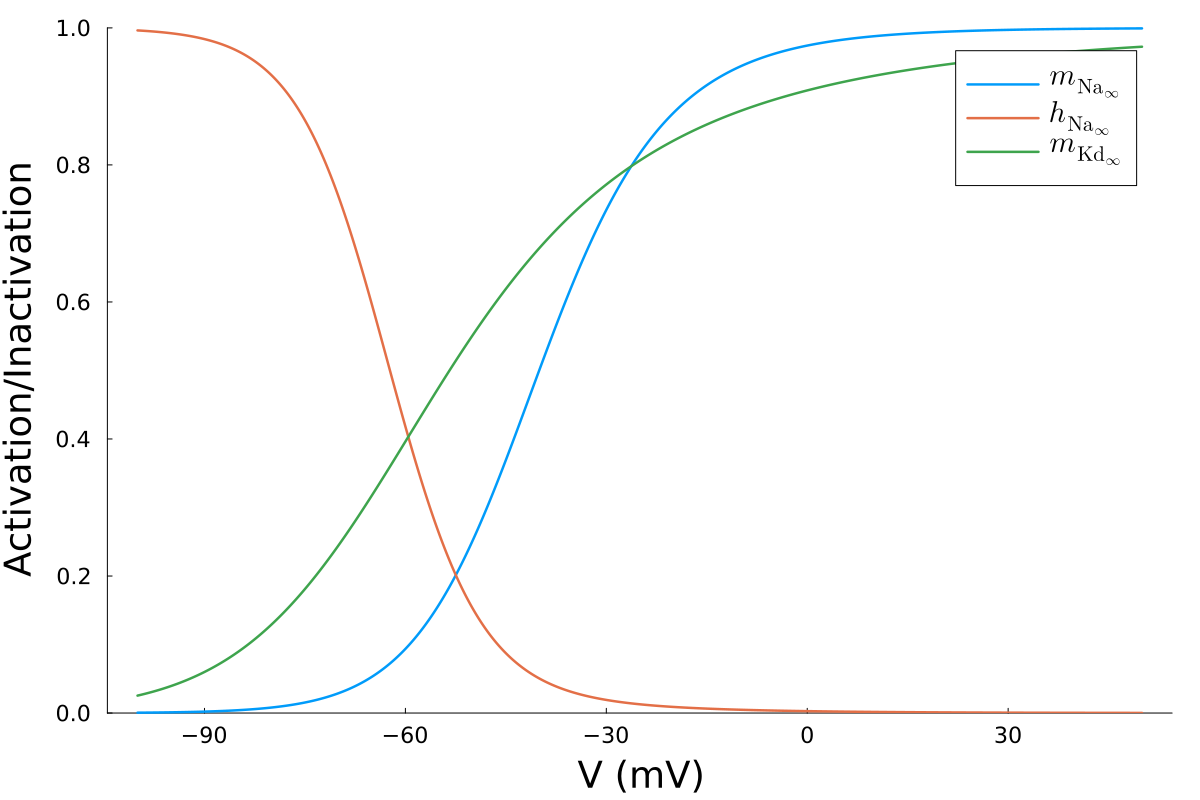

In [8]:
plot(Vrange, m_inf.(Vrange), linewidth=2.5, label=L"m_\mathrm{Na_\infty}",
    legend=true, ylims=(0, 1), margins=20Plots.px, size=(1200, 800), legendfontsize=20)
plot!(Vrange, h_inf.(Vrange), linewidth=2.5, label=L"h_\mathrm{Na_\infty}")
plot!(Vrange, n_inf.(Vrange), linewidth=2.5, label=L"m_\mathrm{Kd_\infty}")
ylabel!("Activation/Inactivation")
xlabel!("V (mV)")

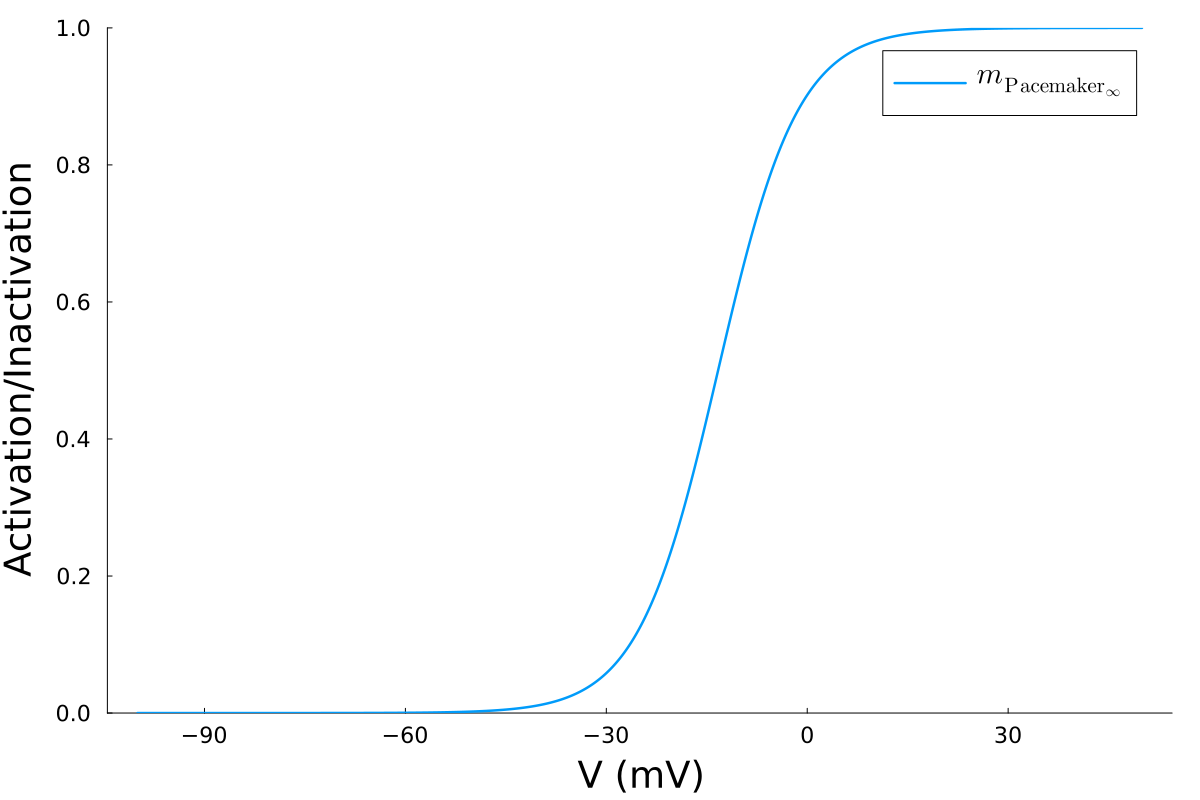

In [9]:
plot(Vrange, mPacemaker_inf.(Vrange), linewidth=2.5, label=L"m_\mathrm{Pacemaker_\infty}",
    legend=true, ylims=(0, 1), margins=20Plots.px, size=(1200, 800), legendfontsize=20)
ylabel!("Activation/Inactivation")
xlabel!("V (mV)")

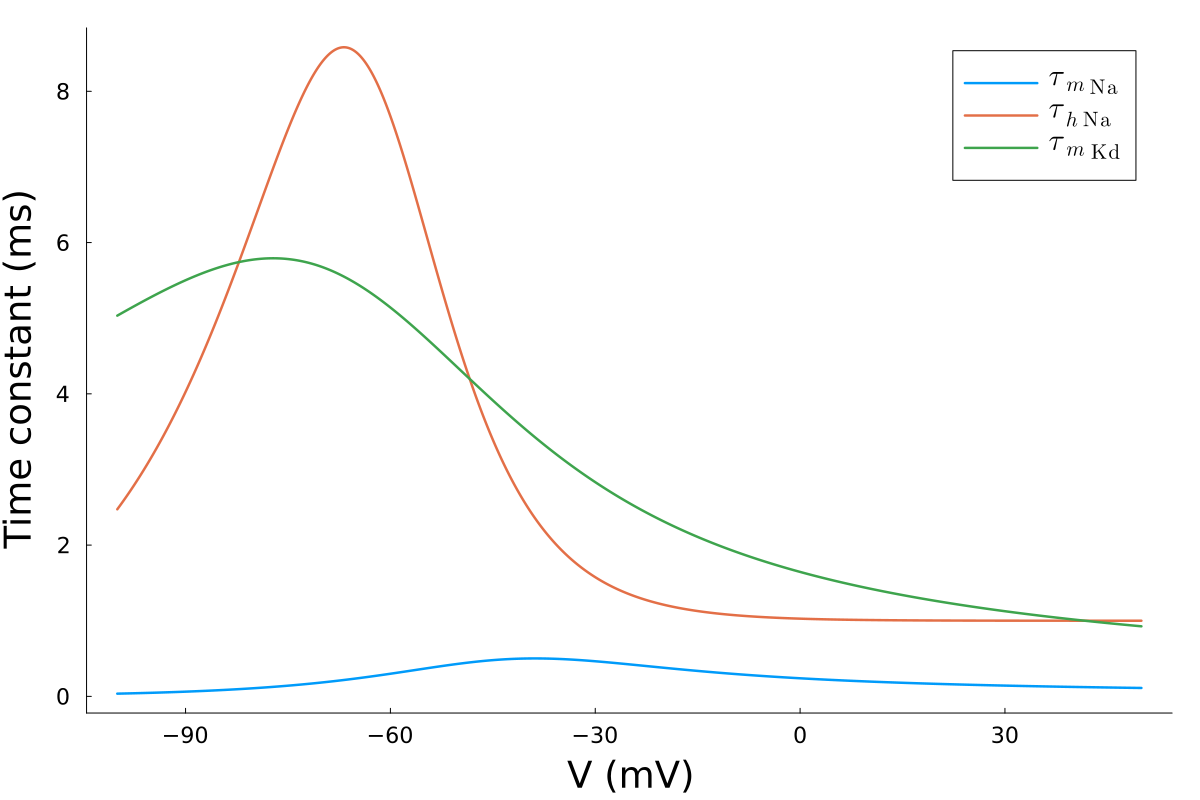

In [10]:
plot(Vrange, tau_m.(Vrange), linewidth=2.5, label=L"\tau_m_\mathrm{Na}",
    legend=true, margins=20Plots.px, size=(1200, 800), legendfontsize=20)
plot!(Vrange, tau_h.(Vrange), linewidth=2.5, label=L"\tau_h_\mathrm{Na}")
plot!(Vrange, tau_n.(Vrange), linewidth=2.5, label=L"\tau_{m}_\mathrm{Kd}")
ylabel!("Time constant (ms)")
xlabel!("V (mV)")

In [11]:
## HH model
function HH_ODE(du, u, p, t)
    # Parameters
    Iapp       = p[1](t) # Amplitude of constant applied current
    gNa        = p[2] # Sodium current maximal conductance
    gKd        = p[3] # Delayed-rectifier potassium current maximal conductance
    gL         = p[4] # Leak non specific current maximal conductance
    gPacemaker = p[5] # Pacemaking current maximal conductance
    xhalf      = p[6]
    
    # Variables
    V    = u[1] # Membrane potential
    m    = u[2] # Sodium current activation
    h    = u[3] # Sodium current inactivation
    n    = u[4] # Delayed-rectifier potassium current activation

    # ODEs
    du[1]= 1/C*(- gNa*m^3*h*(V-VNa) - gKd*n^4*(V-VK) - gL*(V-VL) - 
           gPacemaker*mPacemaker_inf_parametrized(V,  xhalf)*(V-EPacemaker) + Iapp)

    du[2] = (1/tau_m(V)) * (m_inf(V) - m)
    du[3] = (1/tau_h(V)) * (h_inf(V) - h)
    du[4] = (1/tau_n(V)) * (n_inf(V) - n)
end;

# DA model

In [12]:
DA_m_inf(V) = boltz(V, -10., 13.2)
DA_tau_m(V) = 0.01 + 1.0 / ((-(15.6504 + 0.4043*V)/(exp(-19.565 -0.5052*V)-1.0)) + 3.0212*exp(-7.4630e-3*V))
DA_h_inf(V) = boltz(V, -54., -12.8)
DA_tau_h(V) = 0.4 + 1.0 / ((5.0754e-4*exp(-6.3213e-2*V)) + 9.7529*exp(0.13442*V))
DA_n_inf(V) = boltz(V, -25., 12.)
DA_tau_n(V) = (27.2598 / (1+exp(-(V+61.1253)/4.4429))) * (1 / (1+exp((V+36.8869)/9.7083)) + 0.0052) + 0.8876;

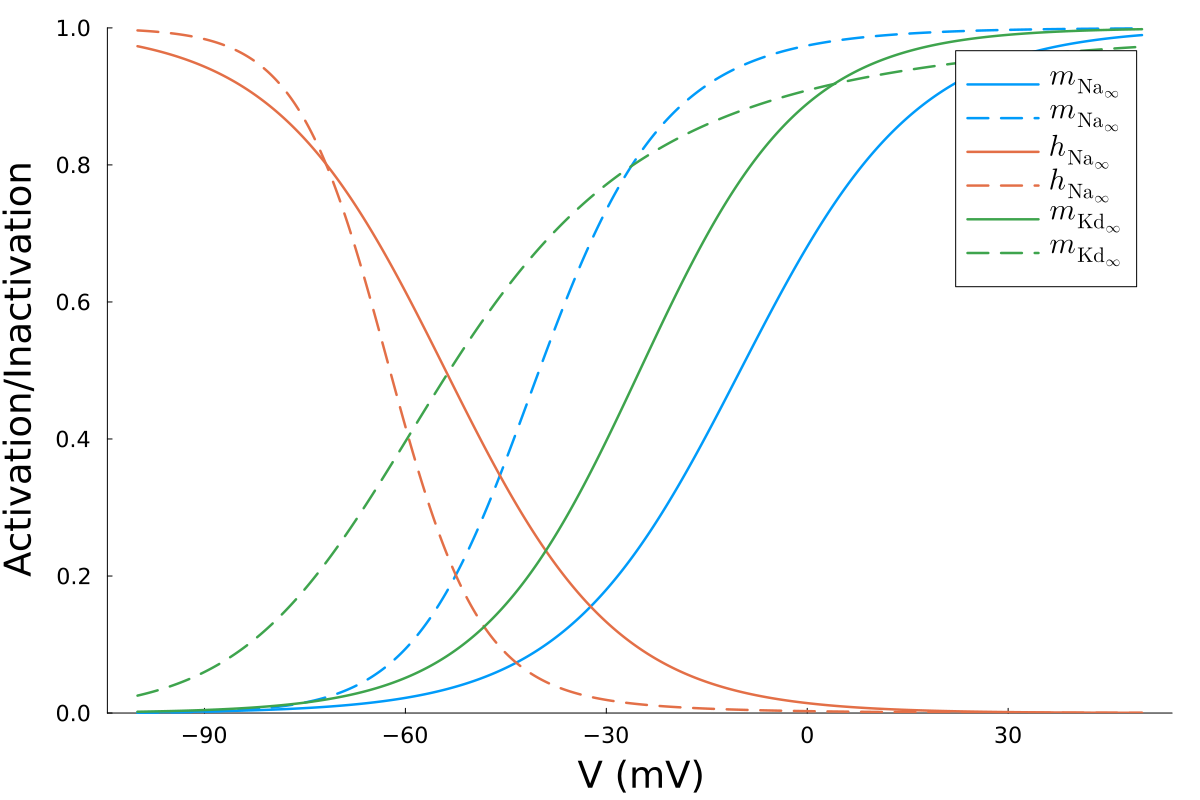

In [13]:
plot(Vrange, DA_m_inf.(Vrange), linewidth=2.5, label=L"m_\mathrm{Na_\infty}",
    legend=true, ylims=(0, 1), margins=20Plots.px, size=(1200, 800), legendfontsize=20)
plot!(Vrange, m_inf.(Vrange), linewidth=2.5, color=1, linestyle=:dash, label=L"m_\mathrm{Na_\infty}")
plot!(Vrange, DA_h_inf.(Vrange), linewidth=2.5, color=2, label=L"h_\mathrm{Na_\infty}")
plot!(Vrange, h_inf.(Vrange), linewidth=2.5, color=2, linestyle=:dash, label=L"h_\mathrm{Na_\infty}")
plot!(Vrange, DA_n_inf.(Vrange), linewidth=2.5, color=3, label=L"m_\mathrm{Kd_\infty}")
plot!(Vrange, n_inf.(Vrange), linewidth=2.5, color=3, linestyle=:dash, label=L"m_\mathrm{Kd_\infty}")
ylabel!("Activation/Inactivation")
xlabel!("V (mV)")

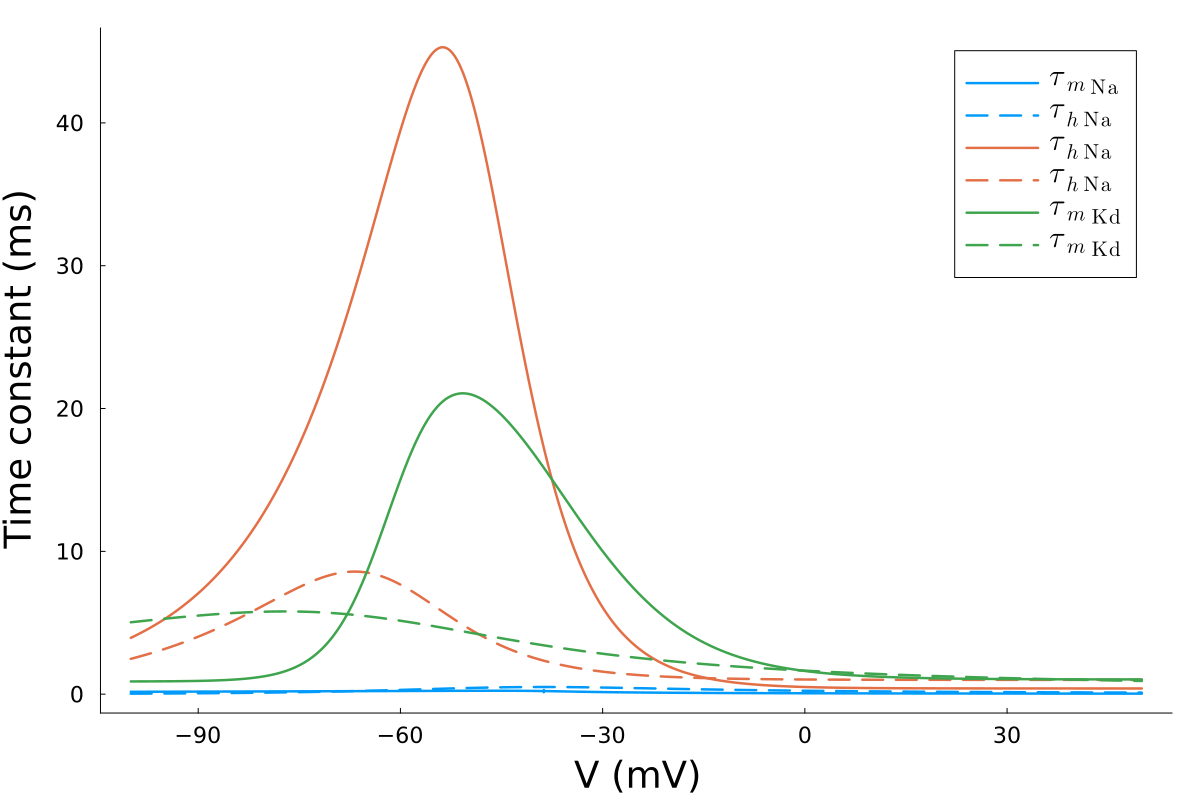

In [14]:
plot(Vrange, DA_tau_m.(Vrange), linewidth=2.5, label=L"\tau_m_\mathrm{Na}",
    legend=true, margins=20Plots.px, size=(1200, 800), legendfontsize=20)
plot!(Vrange, tau_m.(Vrange), linewidth=2.5, color=1, linestyle=:dash, label=L"\tau_h_\mathrm{Na}")
plot!(Vrange, DA_tau_h.(Vrange), linewidth=2.5, color=2, label=L"\tau_h_\mathrm{Na}")
plot!(Vrange, tau_h.(Vrange), linewidth=2.5, color=2, linestyle=:dash, label=L"\tau_h_\mathrm{Na}")
plot!(Vrange, DA_tau_n.(Vrange), linewidth=2.5, color=3, label=L"\tau_{m}_\mathrm{Kd}")
plot!(Vrange, tau_n.(Vrange), linewidth=2.5, color=3, linestyle=:dash, label=L"\tau_{m}_\mathrm{Kd}")
ylabel!("Time constant (ms)")
xlabel!("V (mV)")

In [15]:
## DA model
function DA_ODE(du, u, p, t)
    # Parameters
    Iapp       = p[1](t) # Amplitude of constant applied current
    gNa        = p[2] # Sodium current maximal conductance
    gKd        = p[3] # Delayed-rectifier potassium current maximal conductance
    gL         = p[4] # Leak non specific current maximal conductance
    gPacemaker = p[5] # Pacemaking current maximal conductance
    
    # Variables
    V    = u[1] # Membrane potential
    m    = u[2] # Sodium current activation
    h    = u[3] # Sodium current inactivation
    n    = u[4] # Delayed-rectifier potassium current activation

    # ODEs
    du[1]= 1/C*(- gNa*m^3*h*(V-DA_VNa) - gKd*n^3*(V-DA_VK) - gL*(V-DA_VL) - 
           gPacemaker*mPacemaker_inf(V)*(V-EPacemaker) + Iapp)

    du[2] = (1/DA_tau_m(V)) * (DA_m_inf(V) - m)
    du[3] = (1/DA_tau_h(V)) * (DA_h_inf(V) - h)
    du[4] = (1/DA_tau_n(V)) * (DA_n_inf(V) - n)
end;

# Simu HH model no pacemaker

In [16]:
gNa        = 120. # Sodium current maximal conductance
gKd        = 36. # Delayed-rectifier potassium current maximal conductance
gL         = 0.3 # Leak non specific current maximal conductance
gPacemaker = 0. # Pacemaker current maximal conductance
xhalf = -13.31099526924295

# Input current definition
Iapp(t) = 10 # pA
p = (Iapp, gNa, gKd, gL, gPacemaker, xhalf)

# Initial conditions
V0 = -65.
x0 = [V0, m_inf(V0), h_inf(V0), n_inf(V0)]

# Simulation
prob = ODEProblem(HH_ODE, x0, tspan, p) # Describing the problem
sol = solve(prob; maxiters=1e6) # Solving the problem

# Retrieving variables
x         = sol(tt)
V_plot    = x[1, :];

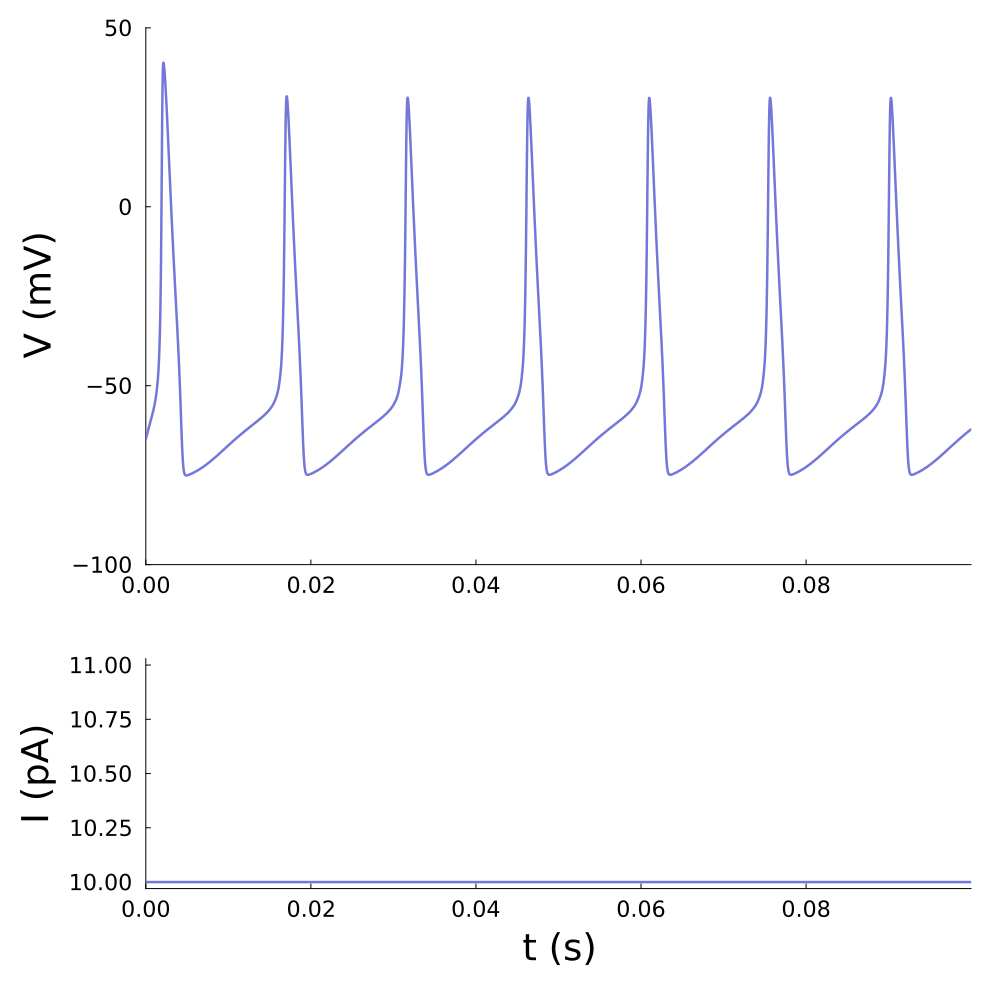

In [17]:
voltage = plot(tt./1e3, V_plot, linewidth=2.5, color=myDarkBlue, 
    legend=false, ylims=(-100, 50), margins=20Plots.px, size=(1200, 800))
ylabel!("V (mV)")

current = plot(tt./1e3, Iapp.(tt), linewidth=2.5, color=myDarkBlue,
    legend=false, margins=20Plots.px, size=(1200, 800))
ylabel!("I (pA)")
xlabel!("t (s)")

l = @layout [
    a{1.0*w, 0.70*h}
    b{1.0*w, 0.30*h}
]
VI = plot(voltage, current, layout=l, size=(1000, 1000), margins=20Plots.px, xlims=(0, 0.1))
display(VI)

# Simu instaneous pacemaker

In [18]:
## HH model
function HH_ODE(du, u, p, t)
    # Parameters
    Iapp        = p[1](t) # Amplitude of constant applied current
    gNa         = p[2] # Sodium current maximal conductance
    gKd         = p[3] # Delayed-rectifier potassium current maximal conductance
    gL          = p[4] # Leak non specific current maximal conductance
    gPacemaker  = p[5] # Pacemaking current maximal conductance
    xhalf       = p[6]
    EPace_param = p[7]
    
    # Variables
    V    = u[1] # Membrane potential
    m    = u[2] # Sodium current activation
    h    = u[3] # Sodium current inactivation
    n    = u[4] # Delayed-rectifier potassium current activation

    # ODEs
    du[1]= 1/C*(- gNa*m^3*h*(V-VNa) - gKd*n^4*(V-VK) - gL*(V-VL) - 
           gPacemaker*mPacemaker_inf_parametrized(V,  xhalf)*(V-EPace_param) + Iapp)

    du[2] = (1/tau_m(V)) * (m_inf(V) - m)
    du[3] = (0.2/tau_h(V)) * (h_inf(V) - h)
    du[4] = (0.2/tau_n(V)) * (n_inf(V) - n)
end;

In [19]:
gNa        = 120. # Sodium current maximal conductance
gKd        = 36. # Delayed-rectifier potassium current maximal conductance
gL         = 0. # Leak non specific current maximal conductance
gPacemaker = 60. # Pacemaker current maximal conductance
xhalf = -15.
EPace_param = 0.

# Input current definition
Iapp(t) = 0 # pA
p = (Iapp, gNa, gKd, gL, gPacemaker, xhalf, EPace_param)

# Initial conditions
V0 = -65.
x0 = [V0, m_inf(V0), h_inf(V0), n_inf(V0)]

# Simulation
prob_pace = ODEProblem(HH_ODE, x0, tspan, p) # Describing the problem
sol_pace = solve(prob_pace; maxiters=1e6) # Solving the problem

# Retrieving variables
x_pace      = sol_pace(tt)
V_plot_pace = x_pace[1, :];

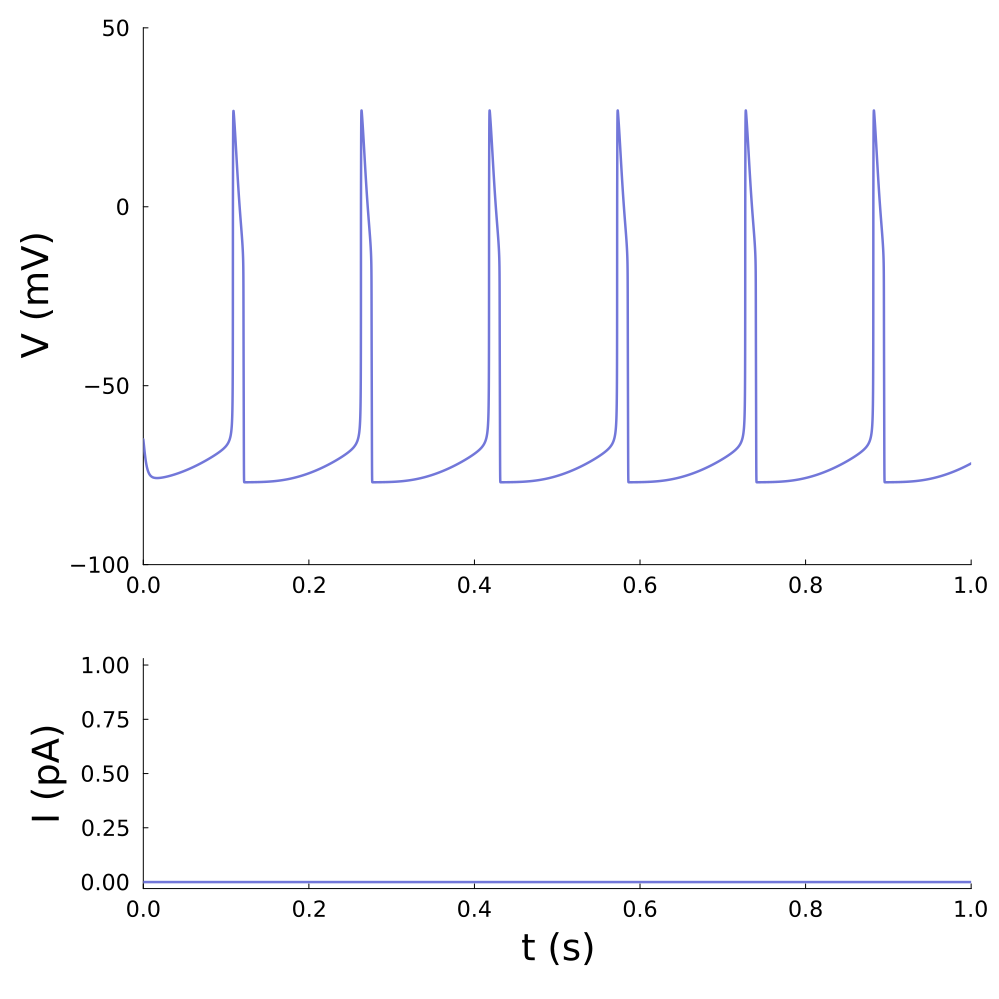

In [20]:
voltage = plot(tt./1e3, V_plot_pace, linewidth=2.5, color=myDarkBlue, 
    legend=false, ylims=(-100, 50), margins=20Plots.px, size=(1200, 800))
ylabel!("V (mV)")

current = plot(tt./1e3, Iapp.(tt), linewidth=2.5, color=myDarkBlue,
    legend=false, margins=20Plots.px, size=(1200, 800))
ylabel!("I (pA)")
xlabel!("t (s)")

l = @layout [
    a{1.0*w, 0.70*h}
    b{1.0*w, 0.30*h}
]
VI = plot(voltage, current, layout=l, size=(1000, 1000), margins=20Plots.px, xlims=(0, 1.))
display(VI)

In [21]:
## HH model
function HH_ODE_reduced(du, u, p, t)
    # Parameters
    Iapp       = p[1](t) # Amplitude of constant applied current
    gNa        = p[2] # Sodium current maximal conductance
    gKd        = p[3] # Delayed-rectifier potassium current maximal conductance
    gL         = p[4] # Leak non specific current maximal conductance
    gPacemaker = p[5] # Pacemaking current maximal conductance
    xhalf      = p[6]
    EPace_param = p[7]
    
    # Variables
    V    = u[1] # Membrane potential
    n    = u[2] # Delayed-rectifier potassium current activation

    # ODEs
    du[1]= 1/C*(- gNa*m_inf(V)^3*h_inf(Vs(n))*(V-VNa) - gKd*n^4*(V-VK) - gL*(V-VL) - 
           gPacemaker*mPacemaker_inf_parametrized(V,  xhalf)*(V-EPace_param) + Iapp)

    du[2] = (0.2/tau_n(V)) * (n_inf(V) - n)
end;

In [22]:
gNa        = 120. # Sodium current maximal conductance
gKd        = 36. # Delayed-rectifier potassium current maximal conductance
gL         = 0. # Leak non specific current maximal conductance
gPacemaker = 90. # Pacemaker current maximal conductance
xhalf = -13.3
EPace_param = 0.

# Input current definition
Iapp(t) = 0 # pA
p = (Iapp, gNa, gKd, gL, gPacemaker, xhalf, EPace_param)

# Initial conditions
V0 = -65.
x0 = [V0, n_inf(V0)]

# Simulation
prob_pace = ODEProblem(HH_ODE_reduced, x0, tspan, p) # Describing the problem
sol_pace = solve(prob_pace; maxiters=1e6) # Solving the problem

# Retrieving variables
x_pace      = sol_pace(tt)
V_plot_pace = x_pace[1, :];

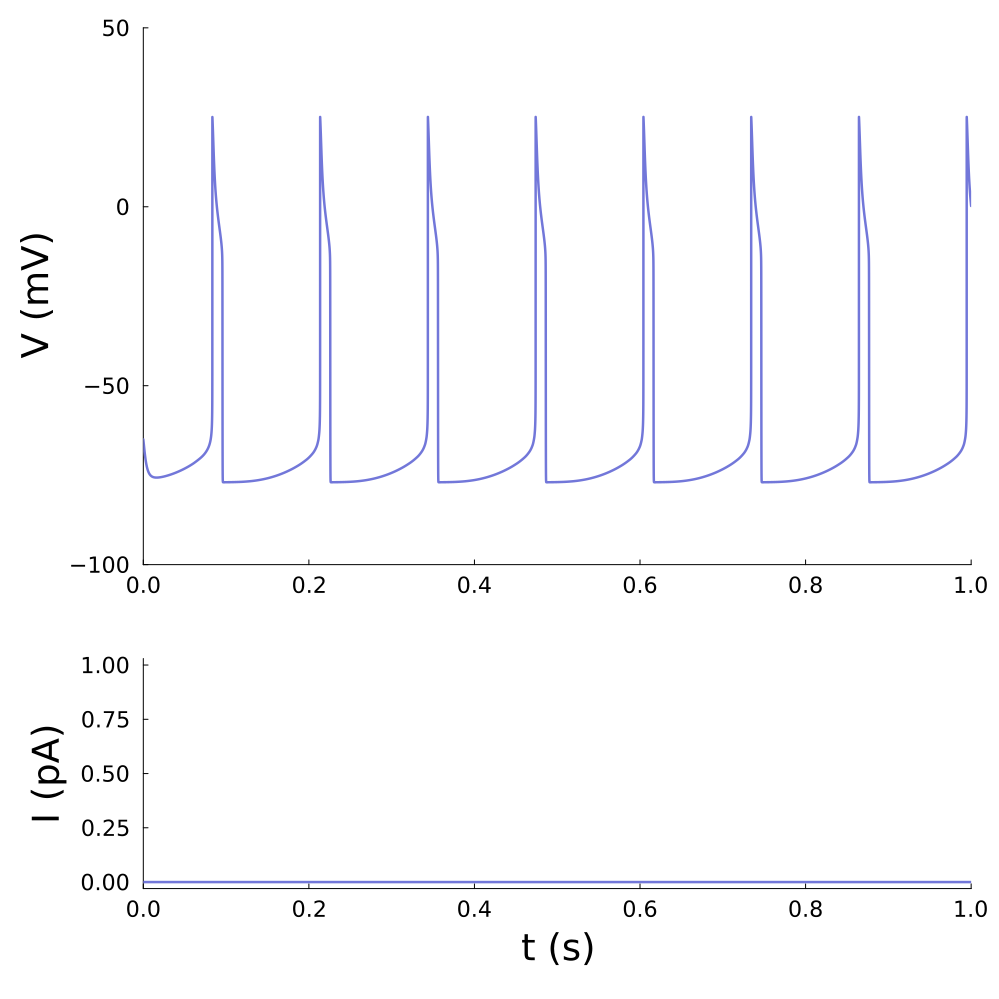

In [23]:
voltage = plot(tt./1e3, V_plot_pace, linewidth=2.5, color=myDarkBlue, 
    legend=false, ylims=(-100, 50), margins=20Plots.px, size=(1200, 800))
ylabel!("V (mV)")

current = plot(tt./1e3, Iapp.(tt), linewidth=2.5, color=myDarkBlue,
    legend=false, margins=20Plots.px, size=(1200, 800))
ylabel!("I (pA)")
xlabel!("t (s)")

l = @layout [
    a{1.0*w, 0.70*h}
    b{1.0*w, 0.30*h}
]
VI = plot(voltage, current, layout=l, size=(1000, 1000), margins=20Plots.px, xlims=(0, 1.))
display(VI)

# Simu DA pacemaker

In [24]:
gNa        = 25. # Sodium current maximal conductance
gKd        = 10. # Delayed-rectifier potassium current maximal conductance
gL         = 0.01 # Leak non specific current maximal conductance
gPacemaker = 5. # Pacemaker current maximal conductance

# Input current definition
Iapp(t) = 0 # pA
p = (Iapp, gNa, gKd, gL, gPacemaker)

# Initial conditions
V0 = -65.
x0 = [V0, m_inf(V0), h_inf(V0), n_inf(V0)]

# Simulation
prob_DA = ODEProblem(DA_ODE, x0, tspan, p) # Describing the problem
sol_DA = solve(prob_DA; maxiters=1e6) # Solving the problem

# Retrieving variables
x_DA      = sol_DA(tt)
V_plot_DA = x_DA[1, :];

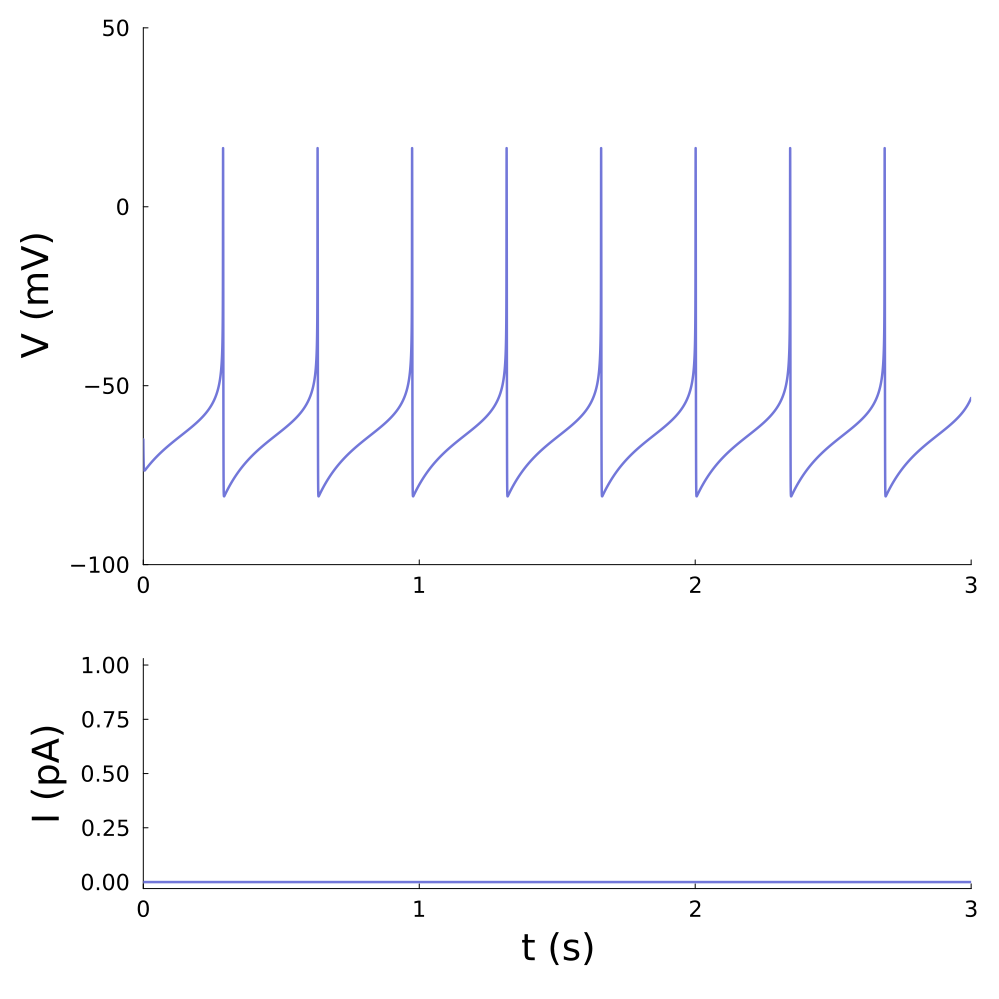

In [25]:
voltage = plot(tt./1e3, V_plot_DA, linewidth=2.5, color=myDarkBlue, 
    legend=false, ylims=(-100, 50), margins=20Plots.px, size=(1200, 800))
ylabel!("V (mV)")

current = plot(tt./1e3, Iapp.(tt), linewidth=2.5, color=myDarkBlue,
    legend=false, margins=20Plots.px, size=(1200, 800))
ylabel!("I (pA)")
xlabel!("t (s)")

l = @layout [
    a{1.0*w, 0.70*h}
    b{1.0*w, 0.30*h}
]
VI = plot(voltage, current, layout=l, size=(1000, 1000), margins=20Plots.px, xlims=(0, 3))
display(VI)

In [26]:
using ImplicitPlots

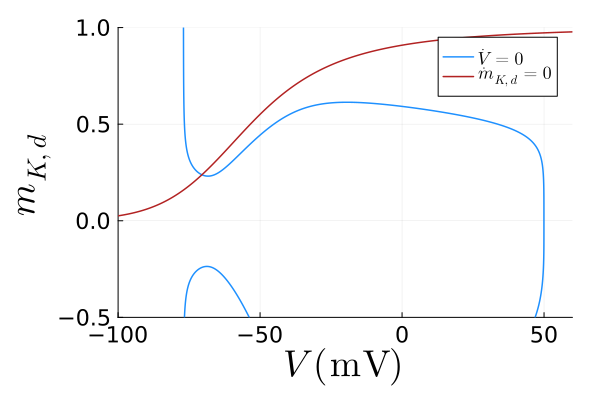

In [28]:
                         # Sodium current
dot_V2(V, n) = (- gNa*m_inf(V)^3*h_inf(Vs(n))*(V-VNa) - gKd*n^4*(V-VK) - gL*(V-VL))

dot_mKd(V, n) = n_inf(V) - n

p = implicit_plot(dot_V2, linewidth=1.5, xlims=(-100, 60), ylims=(-0.5, 1), 
              aspect_ratio=:auto, linecolor=:dodgerblue, label=L"\dot V = 0")
implicit_plot!(dot_mKd, linewidth=1.5, xlims=(-100, 60), ylims=(-0.5, 1), 
               aspect_ratio=:auto, linecolor=:firebrick, label=L"\dot m_{K,d} = 0")
# plot!(x[1, :], x[2, :], linewidth=1.5, linecolor=myGray, label=L"Trajectory")
xlabel!(L"V\ (\mathrm{mV})")
ylabel!(L"m_{K,d}")
# savefig(p, "./figures/phase_plane_original.pdf")
# savefig(p, "./figures/phase_plane_original.svg")